<a href="https://colab.research.google.com/github/yeahsilver/Vision_Study/blob/main/3_MLP_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. MLP Training

In [6]:
import torch
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## 1. MNIST train, test dataset 가져오기
> MNIST 데이터는 필기 숫자의 분류를 위한 학습 데이터 집합

In [7]:
# 모델 학습에 사용할 데이터셋을 불러오는 역할
import torchvision.datasets as dset

### **torchvision.datasets** 매개변수는 다음과 같다.
- ##### `root`: train/test 데이터가가 저장되어어 있는 경로
- ##### `train`: training/test 데이터셋 구별
- ##### `download`: 인터넷에 데이터를 저장할지 여부
- ##### `transform`: transformation feature 설정

In [8]:
# 모델 학습에 사용할 데이터셋을 변형하는 역할
import torchvision.transforms as transforms

In [9]:
mnist_train = dset.MNIST(root="", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



## 2. 대략적인 데이터 형태

In [10]:
print("mnist_train 길이: ", len(mnist_train))
print("mnist_test 길이: ", len(mnist_test))

mnist_train 길이:  60000
mnist_test 길이:  10000


In [11]:
# 데이터 하나에 대한 형태 출력
image, label = mnist_train.__getitem__(0)
print("image data 형태: ", image.size())
print("label: ", label)

image data 형태:  torch.Size([1, 28, 28])
label:  5


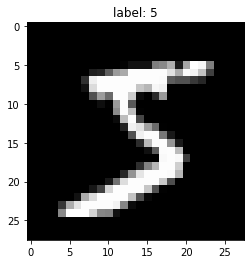

In [12]:
# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')

## 3. 데이터 로드 함수
> 학습시 batch_size 단위로 끊어 로드하기 위해 사용

- `batch_size`: 연산 한번에 들어가는 데이터의 크기
- `learning_rate`: 어느 정도의 크기로 기울기가 줄어드는 지점으로 이동하겠는가를 나타내는 지표
- `num_epoch`: 모든 학습 데이터셋을 학습하는 횟수



In [13]:
# hyper parameters
batch_size = 1024
learning_rate = 0.01
num_epoch = 400

In [14]:
train_loader = torch.utils.data.DataLoader(mnist_train, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2,
                                           drop_last=True) # batch_size 만큼 나눌 떄 나머지는 버리는 매개변수

test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2,
                                          drop_last=True)

### 데이터 로드 함수

[0]
한번에 로드되는 데이터 크기 1024
(28, 28)
(28, 28)
(28, 28)
(28, 28)


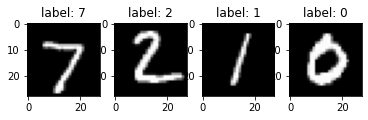

[1]
한번에 로드되는 데이터 크기 1024
(28, 28)
(28, 28)
(28, 28)
(28, 28)


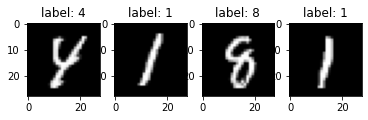

[2]
한번에 로드되는 데이터 크기 1024
(28, 28)
(28, 28)
(28, 28)
(28, 28)


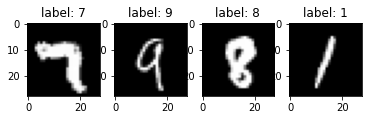

[3]
한번에 로드되는 데이터 크기 1024
(28, 28)
(28, 28)
(28, 28)
(28, 28)


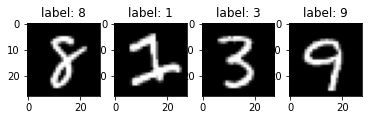

[4]
한번에 로드되는 데이터 크기 1024
(28, 28)
(28, 28)
(28, 28)
(28, 28)


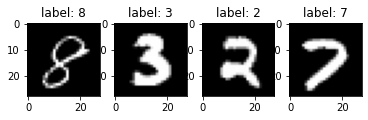

[5]
한번에 로드되는 데이터 크기 1024
(28, 28)
(28, 28)
(28, 28)
(28, 28)


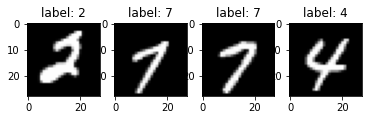

In [15]:
n = 4 # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼 반복
  if i > 5:
    break
  print("[%d]" %i)
  print("한번에 로드되는 데이터 크기", len(imgs))

  # 그리기
  for j in range(n):
    img = imgs[j].numpy()
    img = img.reshape((img.shape[1], img.shape[2]))
    print(img.shape)

    plt.subplot(1, n, j+1)
    plt.imshow(img, cmap="gray")
    plt.title("label: %d" %labels[j])
  plt.show()

## 4. 모델 선언

##### **torch.nn**
torch.nn은 pytorch의 모든 neural network base class이다

In [16]:
import torch.nn as nn

- `linear`
  - Linear layer, Fully connected layer, Dense layer...
  - 다수의 복수레이어를 사용. 
  - 각 레이어마다 입력 데이터의 패턴을 학습하고 다음 레이어는 앞에서 학습한 패턴을 기반으로 학습을 이어나감
  - 선형변환을 활용하여 데이터를 특정 차원으로 변환

- `non-linear`
> 입력을 받아 수학적 변환을 적용하고 출력을 생성하는 함수

  - Sigmoid
    - 출력값의 범위가 0~1사이이며,매우 매끄러운 곡선을 가지므로 경사하강법을 시행할 때 기울기가 급격하게 발산하는 기울기 폭주가 발생하지 않는다.
    - 분류는 0과 1로 나뉘며, 출력값이 어느 값에 가까운지를 통해 어느 분류에 속하는지 쉽게 알 수 있다.

</br>

##### Reference
- https://ehdgns.tistory.com/64

In [17]:
# 모델 선언
# * 퍼셉트론 (2 hidden layer) *
model = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.Sigmoid(),
        nn.Linear(256, 128),
        nn.Linear(128, 10)
)

# 파라미터 보기
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0183,  0.0280, -0.0170,  ...,  0.0130, -0.0126, -0.0037],
        [-0.0081, -0.0143,  0.0073,  ...,  0.0213,  0.0042, -0.0087],
        [-0.0205,  0.0271,  0.0238,  ..., -0.0223, -0.0024, -0.0260],
        ...,
        [-0.0262, -0.0057,  0.0350,  ...,  0.0223,  0.0190,  0.0011],
        [-0.0158,  0.0044, -0.0013,  ...,  0.0209,  0.0344, -0.0088],
        [-0.0357,  0.0050, -0.0100,  ..., -0.0287,  0.0095, -0.0105]],
       requires_grad=True), Parameter containing:
tensor([-0.0280, -0.0339, -0.0257, -0.0138, -0.0325, -0.0320, -0.0203,  0.0304,
         0.0336, -0.0319, -0.0021,  0.0252,  0.0214,  0.0182, -0.0062,  0.0312,
         0.0244,  0.0226,  0.0084, -0.0194,  0.0340, -0.0235,  0.0191, -0.0188,
        -0.0134,  0.0066,  0.0159,  0.0298,  0.0005, -0.0008, -0.0338, -0.0317,
        -0.0307,  0.0200, -0.0180, -0.0145,  0.0336,  0.0080,  0.0073,  0.0349,
         0.0237, -0.0103, -0.0322,  0.0193, -0.0207,  0.0074,  0.0188, -0.0066,
        -0.00

In [18]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader): 
    img = imgs # x-axis
    label = Variable(labels) # y-axis

    # (batch_size, 1, 28, 28) -> (batch_size, 28, 28)
    img = img.reshape((img.shape[0], img.shape[2], img.shape[3])) 
    # (batch_size, 28, 28) -> (batch_size, 28*28)
    img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
    img = Variable(img, requires_grad=False)

    output = imodel(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()
  print("Accuracy of Test Data: {}". format(100*correct/total))

In [19]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 9.87413215637207


## 5. Loss, Optimizer

In [20]:
loss_func = nn.CrossEntropyLoss() # 머신러닝의 분류 모델이 얼마나 잘 수행 되는지 측정
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # 경사하강법. 전체 데이터를 가지고 batch단위로 loss function을 계산

## 6. 학습

In [ ]:
for i in range(num_epoch):
  for j, [imgs, labels] in enumerate(train_loader):
    img = imgs
    label = Variable(labels)

    img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
    img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
    img = Variable(img, requires_grad=True)

    optimizer.zero_grad() # zero_grad()를 하지 않고 역전파를 시키면 이전 루프에서 grad에 저장된 값이 다음 루프의 업데이트에 간섭 (.grad 값을 0으로 초기화)
    output = model(img)
    loss = loss_func(output, label)

    loss.backward() # 각 파라미터의 .grad값 변화
    optimizer.step()

  if i % 50 == 0:
    print("%d.." %i)
    ComputeAccr(test_loader, model)
    print(loss)

0..
Accuracy of Test Data: 11.295573234558105
tensor(2.2977, grad_fn=<NllLossBackward0>)
50..
Accuracy of Test Data: 80.77256774902344
tensor(0.6938, grad_fn=<NllLossBackward0>)
100..
Accuracy of Test Data: 88.24869537353516
tensor(0.4590, grad_fn=<NllLossBackward0>)
150..
Accuracy of Test Data: 89.80034637451172
tensor(0.3803, grad_fn=<NllLossBackward0>)
200..
Accuracy of Test Data: 90.66840362548828
tensor(0.2969, grad_fn=<NllLossBackward0>)
250..
Accuracy of Test Data: 91.24349212646484
tensor(0.2844, grad_fn=<NllLossBackward0>)
300..
Accuracy of Test Data: 91.57986450195312
tensor(0.3261, grad_fn=<NllLossBackward0>)
350..
Accuracy of Test Data: 91.85112762451172
tensor(0.2763, grad_fn=<NllLossBackward0>)


## 7. 테스트

In [22]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 91.98133850097656
